<a href="https://colab.research.google.com/github/KozinIlya/Test/blob/main/Test_Kozin_Ilya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Комментарии к работе:

Получившийся скрипт считает долго и есть предположение что эффективнее было бы вытащить revenue методом описанным в [здесь](https://konstantinklepikov.github.io/2020/03/30/preprocessing-of-json-data-to-pandas-on-python.html)

 Для "быстрого" учета статистической значимости обрезал выбросы снизу. Апппаратные методы (метод 3-х сигм, отбрасывание n-го процентиля) хорошего результата не дали, поэтому нижний порог для количества просмотров подобрал исходя из "экспертной оценки".
Более хорошим был бы вариант сглаживания среднего значения revenue для пользователей с маленьким количеством просмотров по формуле: 
Сглаженный_mean = сумма_revenue+a*global_mean/count_revenue +а

Где: а - коэффициент сглаживания.


 Из интересных особенностей стоит отметить, что хотя основной доход, приносят большие города, их нет в топе по eCPM. В целом распределение и дохода и eCPM показывает что подавляющее количество городов имеет минимальные значения манетизации.

 Большое количество просматривало рекламу 1 раз.

 Свежие OS выглядят намного бодрее как по eCPM, так и по сумме доходов. Возможно проблемы в работе приложения на старых OS.



In [ ]:
! gdown --id 1h2eXP4EyL8hYT2kZ0wmShAtp8Qz8HpNq

In [ ]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/us events ad_revenue filtered 03.02-07.02.csv')
df.head(1)

In [ ]:
#Удаляем ненужные данные
df1 = df.drop(columns=['device_manufacturer', 'device_model','device_type','device_locale',
                       'event_name','connection_type','operator_name','country_iso_code',
                       'event_timestamp','event_receive_datetime','event_receive_timestamp'])
df1 = df1.dropna(subset=['profile_id'])                           #удаляем строки без ID
df1['event_datetime'] = pd.to_datetime(df1['event_datetime'])     # меняем формат на datetime
df1.info()
#df1 = df1.head(10000)        # ограничение строк для отладки скрипта

In [ ]:
#Создаем новый датафрейм с столбцом revenue (из столбца event_json)
revenue = []
id = []
os = []
datetime = []
city = []

for i, row in df1.iterrows():
  t = df1['event_json'][i]
  data_list = json.loads(t)
  df_1 = json_normalize(data_list)
  p = df_1.revenue.item()
  revenue.append(p)
  id.append(row['profile_id'])
  os.append(row['os_version'])
  datetime.append(row['event_datetime'])
  city.append(row['city'])

  
df_with_revenue = pd.DataFrame({'id':id, 'os':os,'revenue':revenue,'datetime':datetime,'city':city})
df_with_revenue.head(3)

In [ ]:
#Считаем данные по eCPM
iterable_list = ['id','city','os']

fig, axes = plt.subplots(1, 3, figsize=(20,8)) 

for j, i in enumerate(iterable_list):
  agg_func_math = {
      'revenue': ['sum','count', 'mean' ]
  }

  df_with_rev = df_with_revenue.groupby([i]).agg(agg_func_math).reset_index() 
  df_with_rev.columns = [tup[1] if tup[1] else tup[0] for tup in df_with_rev.columns]  #ставим заголовки на один уровень
  
  if i == 'id':
    p = df_with_rev[df_with_rev['count'] > 100]           #убираем юзеров с количеством просмотров >100
    p['eCPM_mean'] = p['mean'] *1000                            #  средний   eCPM на юзера    
    
    axes[j].hist(p['eCPM_mean'], bins=100)
    axes[j].set_ylabel('количество юзеров')
    axes[j].set_title(f"распределение среднего eCPM по {i}")

  else:
    p = df_with_rev[df_with_rev['count'] > 500]                #убираем города  с количеством просмотров >500 (осей с такими параметрами нет)                
    p['eCPM_mean'] = p['mean'] *1000         #  средний   eCPM на ось/город
    
    if i == 'os':

      axes[j].bar(p['os'],p['eCPM_mean'])
      axes[j].set_ylabel('средний eCPM')
      axes[j].set_xlabel('версия OS')
      axes[j].set_title(i)

    elif i == 'city':
      axes[j].hist(p['eCPM_mean'], bins=100)
      axes[j].set_ylabel('количество городов')
      axes[j].set_title(f"распределение среднего eCPM по {i}")
  


  print()
  print( )
  print(f"         Топ10 {i} по eCPM_mean")
  print()
  display(p.sort_values(by = 'eCPM_mean', ascending=False).head(10))




         Топ city по суммарным доходам



,city,revenue
585,New York,47.45
388,Indianapolis,36.68
377,Houston,34.55
540,Minneapolis,34.24
161,Cleveland,32.48
140,Charlotte,25.62
172,Columbus,22.16
483,Los Angeles,19.74
792,Spokane,18.92
197,Dallas,18.75




         Топ os по суммарным доходам



,os,revenue
2,12,1305.58
1,11,587.16
0,10,328.27
10,9,133.11
8,8.0.0,11.89
5,7.0,10.95
9,8.1.0,9.79
6,7.1.1,1.62
7,7.1.2,1.09
4,6.0.1,0.78


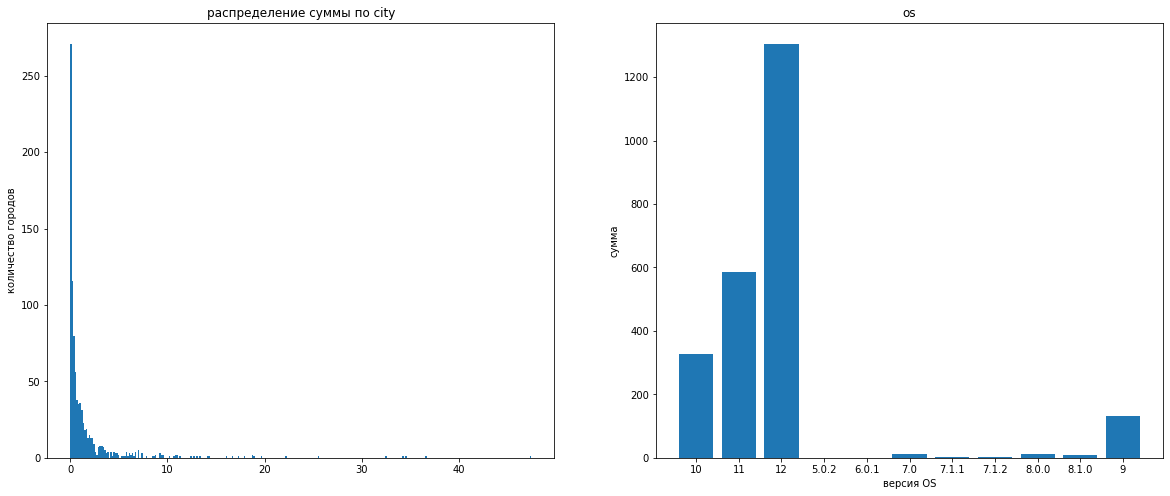

In [147]:
#сумарные доходы по городам и OS
fig, axes = plt.subplots(1, 2, figsize=(20,8))
spisok = ['city', 'os']

for j, i in enumerate(spisok):
  sum_i = df_with_revenue.groupby(df_with_revenue[i])[['revenue']].sum().round(2).reset_index()

  if i ==('city'):

    axes[j].hist(sum_i['revenue'], bins=300)
    axes[j].set_ylabel('количество городов')
    axes[j].set_title(f"распределение суммы по {i}")

  else:

    axes[j].bar(sum_i['os'],sum_i['revenue'],)
    axes[j].set_ylabel('сумма')
    axes[j].set_xlabel('версия OS')
    axes[j].set_title(i)



  print()
  print( )
  print(f"         Топ {i} по суммарным доходам")
  print()
  display(sum_i.sort_values(by = 'revenue', ascending=False).head(20))
  